Harika\! Tüm yoldaki hataları (Drive, dosya adı, Tensör/NumPy uyumsuzluğu) düzelttik ve eğitim adımlarını tamamladık.

İşte en son haliyle, **4D girdi hatasını yakalayan ve eğitim adımlarını doğru uygulayan** nihai notebook kodunuz. Bu yapıda, kodunuz hücre hücre çalışmaya hazırdır.

-----

# 💻 Nihai Jupyter Notebook Kodu (Eksiksiz ve Çalışmaya Hazır)

## 1\. Hücre 1.1: Kurulum, Sabitler ve Drive Bağlantısı 🔗

In [ ]:
# Google Drive'ı Colab ortamına bağlama
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive başarıyla bağlandı!")

# Kütüphane İçe Aktarımları
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Sabitler ve Dizinler
# KRİTİK DÜZELTME: DRIVE YOLU
DATA_ROOT = '/content/drive/MyDrive/crema_d/AudioWAV/'
OUTPUT_DIR = './experiments_log/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Çekirdek (Seed) Ayarları: Tekrarlanabilirlik İçin Paranoyak Önlem
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

# Duygu Etiket Haritalaması
LABEL_MAP = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
NUM_CLASSES = len(LABEL_MAP)
EMOTION_LABELS = list(LABEL_MAP.keys())

# Ortak Öznitelik Ayarları
TARGET_SR = 22050
MAX_LENGTH = 3.5
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128
N_MFCC = 40

# GLOBAL DEĞİŞKEN: Normalizasyon istatistiklerini saklamak için
FEATURE_STATS = {}

Mounted at /content/drive
Google Drive başarıyla bağlandı!
Kullanılan Cihaz: cpu


-----

## 2\. Hücre 1.2: Veri Yükleme, Parsingleme ve Bölme 💾

In [ ]:
def load_audio(file_path):
    """Sesi hedef örnekleme hızında (SR) yükler ve normalleştirir."""
    audio, sr = librosa.load(file_path, sr=TARGET_SR)
    max_samples = int(MAX_LENGTH * sr)
    if len(audio) > max_samples:
        audio = audio[:max_samples] # Kırpma
    elif len(audio) < max_samples:
        padding = np.zeros(max_samples - len(audio))
        audio = np.concatenate((audio, padding)) # Doldurma
    return audio

# Üç harfli CREMA-D kodlarını tek harfli kodlara çeviren harita
EMOTION_CODE_MAPPER = {
    'ANG': 'A', 'DIS': 'D', 'FEA': 'F', 'HAP': 'H', 'NEU': 'N', 'SAD': 'S'
}
VALID_EMOTION_CODES_3CHAR = set(EMOTION_CODE_MAPPER.keys())


def create_cremad_dataframe(data_root):
    file_paths = []
    actor_ids = []
    emotions = []

    for filename in os.listdir(data_root):
        if filename.endswith(".wav"):
            base_filename = filename[:-4]
            parts = base_filename.split('_')

            if len(parts) < 4:
                continue

            emotion_code_3char = parts[2].upper()

            if emotion_code_3char not in VALID_EMOTION_CODES_3CHAR:
                continue

            emotion_code_1char = EMOTION_CODE_MAPPER[emotion_code_3char]
            actor_id = parts[0]

            file_paths.append(os.path.join(data_root, filename))
            actor_ids.append(actor_id)
            emotions.append(emotion_code_1char)

    df = pd.DataFrame({
        'path': file_paths,
        'actor_id': actor_ids,
        'emotion': emotions
    })

    print(f"DEBUG: Başarıyla işlenen toplam dosya sayısı: {len(df)}")

    return df

# Veri Kümesini Yükle ve Aktörlere Göre Böl
df_full = create_cremad_dataframe(DATA_ROOT)

# Konuşmacı Bağımsız Bölme
actor_list = df_full['actor_id'].unique()
train_actors, test_actors = train_test_split(
    actor_list, test_size=0.2, random_state=SEED
)

train_df = df_full[df_full['actor_id'].isin(train_actors)]
test_df = df_full[df_full['actor_id'].isin(test_actors)]

# Sınıf Ağırlıkları Hesaplama (Ağırlıklı Kayıp İçin)
emotion_counts = train_df['emotion'].value_counts()
total_samples = emotion_counts.sum()
class_weights = total_samples / (NUM_CLASSES * emotion_counts)

# PyTorch için ağırlık sırasını LABEL_MAP'e göre ayarlama
sorted_weights = [class_weights[e] for e in EMOTION_LABELS]
WEIGHTS_TENSOR = torch.tensor(sorted_weights, dtype=torch.float32).to(DEVICE)

print(f"Eğitim Konuşmacı Sayısı: {len(train_actors)}")
print(f"Test Konuşmacı Sayısı: {len(test_actors)}")
print(f"Sınıf Ağırlıkları (Tensor): {WEIGHTS_TENSOR}")

DEBUG: Başarıyla işlenen toplam dosya sayısı: 7442
Eğitim Konuşmacı Sayısı: 72
Test Konuşmacı Sayısı: 19
Sınıf Ağırlıkları (Tensor): tensor([0.9758, 0.9758, 0.9758, 0.9758, 1.1416, 0.9758])


-----

## 3\. Hücre 2.1 & 2.2: Ön İşleme ve Öznitelik Çıkarımı 🎶

In [ ]:
# --- Ön İşleme Pipeline Tanımlamaları ---
def preproc_A(audio):
    """Pipeline A: Baseline - Basit Normalizasyon ve Kırpma."""
    return audio

def preproc_B(audio, sr=TARGET_SR):
    """Pipeline B: Veri Büyütme (Augmentation) Odaklı (Pitch Shift + Noise)."""
    pitch_shifted = librosa.effects.pitch_shift(
        audio, sr=sr, n_steps=random.uniform(-4, 4)
    )
    noise_amp = 0.005 * np.random.uniform() * np.amax(pitch_shifted)
    noisy_audio = pitch_shifted + noise_amp * np.random.normal(size=pitch_shifted.shape[0])
    return noisy_audio

def preproc_C(audio):
    """Pipeline C: Sinyal Güçlendirme + RMS Normalizasyonu."""
    rms = np.sqrt(np.mean(audio**2))
    normalized_audio = audio / (rms + 1e-6)
    return normalized_audio

PREPROC_PIPELINES = {
    'A_Baseline': preproc_A,
    'B_Augmentation': preproc_B,
    'C_RMS_Norm': preproc_C
}

# --- Öznitelik Çıkarma Pipeline Tanımlamaları ---
def features_A(audio, sr=TARGET_SR):
    """Features A: MFCC + Delta + Delta-Delta (1D/Zamansal)."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    combined_features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
    return combined_features.T # (Timesteps, Features) -> 2D NumPy

def features_B(audio, sr=TARGET_SR):
    """Features B: Log-Mel Spektrogram + Delta/Delta-Delta (3 Kanallı, 2D/Görsel-Spektral)."""
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    delta = librosa.feature.delta(log_mel_spectrogram)
    delta2 = librosa.feature.delta(log_mel_spectrogram, order=2)
    combined_features = np.stack([log_mel_spectrogram, delta, delta2], axis=0)
    return combined_features # (Channel, Freq, Time) -> 3D NumPy

def features_C(audio, sr=TARGET_SR):
    """Features C: Basit MFCC + Ek Spektral Özellikler (Hibrit 1D)."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_LENGTH)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    combined_features = np.concatenate((mfcc, chroma, centroid, bandwidth), axis=0)
    return combined_features.T # (Timesteps, Features) -> 2D NumPy

FEATURE_PIPELINES = {
    'A_MFCC_Delta': features_A,
    'B_LogMelSpec_3Ch': features_B,
    'C_Hybrid_1D': features_C
}

-----

## 4\. Hücre 2.3: SERDataset Sınıfı (Tensör ve Normalizasyon)

In [ ]:
class SERDataset(Dataset):
    def __init__(self, df, preproc_name, feature_name, stats=None):
        self.df = df
        self.preproc = PREPROC_PIPELINES[preproc_name]
        self.feature_extractor = FEATURE_PIPELINES[feature_name]
        self.labels = [LABEL_MAP[l] for l in df['emotion']]
        self.stats = stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.iloc[idx]['path']
        label = self.labels[idx]

        audio = load_audio(file_path)
        audio = self.preproc(audio)
        features = self.feature_extractor(audio)

        # PyTorch Tensor'a DÖNÜŞÜM
        features_tensor = torch.tensor(features, dtype=torch.float32)

        # Öznitelik Normalizasyonu
        if self.stats:
            mean = self.stats['mean']
            std = self.stats['std']
            features_tensor = (features_tensor - mean) / (std + 1e-6)

        return features_tensor, torch.tensor(label, dtype=torch.long)

-----

## 5\. Hücre 3.1 & 3.2: Model Mimarileri 🧠

In [ ]:
# Aktivasyon Haritası
ACTIVATIONS = {
    'relu': nn.ReLU(),
    'leakyrelu': nn.LeakyReLU(),
    'gelu': nn.GELU()
}

# Dinamik Boyut Hesaplayıcı
def calculate_conv_output_dim(input_tensor_shape, model):
    """Conv/Pooling katmanlarından sonraki düzleştirilmiş (flattened) boyutu hesaplar."""
    # input_tensor_shape: (C, F, T)
    dummy_input = torch.zeros(1, *input_tensor_shape).to(DEVICE)
    with torch.no_grad():
        output = model.features(dummy_input)
        flattened_size = output.numel()
        return flattened_size // output.shape[0]

class Model_CNN_A(nn.Module):
    # ... (Mevcut kod aynı)
    def __init__(self, input_shape, num_classes, activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout_rate)
        )

        flattened_size = calculate_conv_output_dim(input_shape, self)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256), act,
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Model_LSTM_A(nn.Module):
    # ... (Mevcut kod aynı)
    def __init__(self, input_size, num_classes, hidden_size=128, num_layers=2, activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64), act,
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_state = lstm_out[:, -1, :]
        out = self.fc(final_state)
        return out

class Model_CRNN_A(nn.Module):
    # ... (Mevcut kod aynı)
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1, activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate)
        )
        self.features = self.conv

        feature_size_after_conv = 16 * input_shape[1]

        self.rnn = nn.LSTM(feature_size_after_conv, hidden_size, num_layers, batch_first=True,
                            bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        rnn_out, _ = self.rnn(x)
        final_state = rnn_out[:, -1, :]
        out = self.classifier(final_state)
        return out

-----

## 6\. Hücre 4.1: Eğitim ve Değerlendirme Fonksiyonları (DÜZELTİLDİ) ✅

In [ ]:
def evaluate_model(model, data_loader, stage, return_full=False):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in data_loader:
            # Düzeltme: Eğer DataLoader'dan gelen tensörlerde fazladan 1 boyutu varsa kaldır.
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    if return_full:
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=EMOTION_LABELS, zero_division=0)
        # print(f"\n--- {stage} Raporu ---")
        # print(report)
        # print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
        return accuracy, f1, cm, report
    return accuracy, f1

def train_and_evaluate(config, train_df, test_df, weights_tensor):
    """Tek bir deney konfigürasyonunu çalıştıran ana fonksiyon."""

    preproc_name = config['preproc']
    feature_name = config['features']
    batch_size = config['batch_size']
    epochs = config['epochs']

    # --- 1. Normalizasyon İstatistiklerini Hesaplama ---
    temp_dataset = SERDataset(train_df, preproc_name, feature_name, stats=None)
    temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
    features_all, _ = next(iter(temp_loader))

    # Düzeltme: Eğer DataLoader ekstra bir boyut (genellikle 1. index'te) eklemişse kaldır.
    # Bu, normalizasyon istatistiklerinin doğru boyutta hesaplanmasını sağlar.
    if len(features_all.shape) > 2 and features_all.shape[1] == 1:
        features_all = features_all.squeeze(1)

    # Global Mean/Std hesaplama
    mean = features_all.mean(dim=0, keepdim=True).to('cpu')
    std = features_all.std(dim=0, keepdim=True).to('cpu')

    global FEATURE_STATS
    FEATURE_STATS[config['name']] = {'mean': mean, 'std': std}

    # --- 2. Veri Yükleyicileri İstatistiklerle Hazırlama ---
    train_dataset = SERDataset(train_df, preproc_name, feature_name, stats=FEATURE_STATS[config['name']])
    test_dataset = SERDataset(test_df, preproc_name, feature_name, stats=FEATURE_STATS[config['name']])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # --- Model ve Hiperparametre Oluşturma ---
    sample_features, _ = next(iter(train_loader))
    input_shape = sample_features.shape # (Batch, ...)

    # Düzeltme: Eğer DataLoader ekstra bir boyut (genellikle 1. index'te) eklemişse kaldır.
    # Bu, Model'e geçecek feature tensor'larının doğru boyutta olmasını sağlar.
    if len(input_shape) > 2 and input_shape[1] == 1:
        sample_features = sample_features.squeeze(1)
        input_shape = sample_features.shape # Güncellenmiş shape

    # KRİTİK BOYUT KONTROLÜ (LSTM 4D alamaz!) ---
    # Artık input_shape'in ekstra 1 boyutu olmadığı için bu kontrol daha doğru.
    if config['model_type'] == 'LSTM_A' and len(input_shape) == 4:
        print(f"\n!!! DENEK ATLANDI ({config['name']}): LSTM 4D girdi alamaz. (Shape: {input_shape})")
        return # Deneyi atla

    # --- Model İnşası ---
    model_input_shape = input_shape[1:]

    if config['model_type'] == 'LSTM_A':
        model = Model_LSTM_A(input_size=model_input_shape[-1], num_classes=NUM_CLASSES,
                             activation=config['activation'], dropout_rate=config['dropout']).to(DEVICE)
    elif config['model_type'] == 'CNN_A':
        model = Model_CNN_A(input_shape=model_input_shape, num_classes=NUM_CLASSES,
                            activation=config['activation'], dropout_rate=config['dropout']).to(DEVICE)
    elif config['model_type'] == 'CRNN_A':
        model = Model_CRNN_A(input_shape=model_input_shape, num_classes=NUM_CLASSES,
                             activation=config['activation'], dropout_rate=config['dropout']).to(DEVICE)
    else:
        raise ValueError("Bilinmeyen Model Tipi")

    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    elif config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # --- Eğitim Döngüsü ---
    print(f"--- Deney Başlatıldı: {config['name']} ---")
    best_val_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # tqdm döngüsü
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):

            # Düzeltme: Eğer DataLoader'dan gelen tensörlerde fazladan 1 boyutu varsa kaldır.
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)

            features, labels = features.to(DEVICE), labels.to(DEVICE)

            # EĞİTİM ADIMLARI
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc, val_f1 = evaluate_model(model, test_loader, 'Validation')
        print(f"Epoch {epoch+1} - Avg Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth"))

    # --- Test ve Değerlendirme ---
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth")))
    test_acc, test_f1, cm, report = evaluate_model(model, test_loader, 'Test', return_full=True)

    # --- Sonuçları Kaydetme ---
    new_row = {
        'experiment_name': config['name'],
        'preprocessing_pipeline': preproc_name,
        'feature_pipeline': feature_name,
        'model_type': config['model_type'],
        'activation': config['activation'],
        'optimizer': config['optimizer'],
        'learning_rate': config['learning_rate'],
        'dropout': config['dropout'],
        'batch_size': batch_size,
        'epochs': epochs,
        'val_accuracy': best_val_accuracy,
        'val_f1': val_f1,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'confusion_matrix': cm.tolist()
    }

    global RESULTS_DF
    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
import pandas as pd
import os

# Sonuçları kaydedeceğimiz ana tablo
# Eğer daha önce kaydettiğin bir CSV varsa onu yükleyelim ki kaldığın yerden devam etsin
csv_path = 'experiments_results_checkpoint.csv'

if os.path.exists(csv_path):
    RESULTS_DF = pd.read_csv(csv_path)
    print(f"✅ Mevcut kayıt dosyası bulundu ve yüklendi. Toplam {len(RESULTS_DF)} deney var.")
else:
    RESULTS_DF = pd.DataFrame(columns=[
        'experiment_name', 'preprocessing_pipeline', 'feature_pipeline', 'model_type',
        'activation', 'optimizer', 'learning_rate', 'dropout', 'batch_size', 'epochs',
        'val_accuracy', 'val_f1', 'test_accuracy', 'test_f1', 'confusion_matrix'
    ])
    print("🆕 Yeni sonuç tablosu oluşturuldu.")

🆕 Yeni sonuç tablosu oluşturuldu.


In [ ]:
# --- DENEY 1: BASELINE (LSTM + MFCC) ---
config_e01 = {
    'name': 'EXP_E01_LSTM_A_MFCC_Adam',
    'preproc': 'A_Baseline',
    'features': 'A_MFCC_Delta',
    'model_type': 'LSTM_A',
    'activation': 'leakyrelu',
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'dropout': 0.3,
    'batch_size': 64,
    'epochs': 20
}

print(f">>> {config_e01['name']} BAŞLATILIYOR...")

# Deneyi Çalıştır
# Not: train_and_evaluate fonksiyonunun RESULTS_DF'e ekleme yapmadığını varsayarak
# sonucu alıp burda ekliyoruz. Fonksiyonun yapısına göre burayı düzenleyebilirsin.
# Eğer fonksiyonun içinde RESULTS_DF global olarak güncelleniyorsa, sadece fonksiyonu çağır.
train_and_evaluate(config_e01, train_df, test_df, WEIGHTS_TENSOR)

# Her ihtimale karşı CSV'ye yedekle (Checkpoint)
if 'RESULTS_DF' in globals() and not RESULTS_DF.empty:
    RESULTS_DF.to_csv('experiments_results_checkpoint.csv', index=False)
    print("💾 Sonuçlar diske yedeklendi.")

>>> EXP_E01_LSTM_A_MFCC_Adam BAŞLATILIYOR...
--- Deney Başlatıldı: EXP_E01_LSTM_A_MFCC_Adam ---


Epoch 1: 100%|██████████| 92/92 [04:34<00:00,  2.98s/it]


Epoch 1 - Avg Loss: 1.6187, Val Acc: 0.3582


Epoch 2: 100%|██████████| 92/92 [04:32<00:00,  2.96s/it]


Epoch 2 - Avg Loss: 1.5081, Val Acc: 0.3755


Epoch 3: 100%|██████████| 92/92 [04:31<00:00,  2.95s/it]


Epoch 3 - Avg Loss: 1.4760, Val Acc: 0.3723


Epoch 4: 100%|██████████| 92/92 [04:24<00:00,  2.87s/it]


Epoch 4 - Avg Loss: 1.4393, Val Acc: 0.3742


Epoch 5: 100%|██████████| 92/92 [04:27<00:00,  2.91s/it]


Epoch 5 - Avg Loss: 1.4173, Val Acc: 0.3710


Epoch 6: 100%|██████████| 92/92 [04:24<00:00,  2.88s/it]


Epoch 6 - Avg Loss: 1.4070, Val Acc: 0.3806


Epoch 7: 100%|██████████| 92/92 [04:23<00:00,  2.87s/it]


Epoch 7 - Avg Loss: 1.3863, Val Acc: 0.3703


Epoch 8: 100%|██████████| 92/92 [04:23<00:00,  2.87s/it]


Epoch 8 - Avg Loss: 1.3575, Val Acc: 0.3691


Epoch 9: 100%|██████████| 92/92 [04:26<00:00,  2.89s/it]


Epoch 9 - Avg Loss: 1.3472, Val Acc: 0.3729


Epoch 10: 100%|██████████| 92/92 [04:20<00:00,  2.83s/it]


Epoch 10 - Avg Loss: 1.3293, Val Acc: 0.3877


Epoch 11: 100%|██████████| 92/92 [04:18<00:00,  2.81s/it]


Epoch 11 - Avg Loss: 1.3167, Val Acc: 0.3774


Epoch 12: 100%|██████████| 92/92 [04:20<00:00,  2.83s/it]


Epoch 12 - Avg Loss: 1.2997, Val Acc: 0.3870


Epoch 13: 100%|██████████| 92/92 [04:15<00:00,  2.77s/it]


Epoch 13 - Avg Loss: 1.2706, Val Acc: 0.4063


Epoch 14: 100%|██████████| 92/92 [04:13<00:00,  2.75s/it]


Epoch 14 - Avg Loss: 1.2365, Val Acc: 0.3851


Epoch 15: 100%|██████████| 92/92 [04:12<00:00,  2.75s/it]


Epoch 15 - Avg Loss: 1.2101, Val Acc: 0.3967


Epoch 16: 100%|██████████| 92/92 [04:15<00:00,  2.78s/it]


Epoch 16 - Avg Loss: 1.1878, Val Acc: 0.3858


Epoch 17: 100%|██████████| 92/92 [04:15<00:00,  2.78s/it]


Epoch 17 - Avg Loss: 1.1298, Val Acc: 0.3877


Epoch 18: 100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


Epoch 18 - Avg Loss: 1.0704, Val Acc: 0.3960


Epoch 19: 100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


Epoch 19 - Avg Loss: 1.0311, Val Acc: 0.3960


Epoch 20: 100%|██████████| 92/92 [04:15<00:00,  2.78s/it]


Epoch 20 - Avg Loss: 0.9880, Val Acc: 0.3909
💾 Sonuçlar diske yedeklendi.


/tmp/ipython-input-3599225612.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)


In [ ]:
# --- DENEY 3: CNN (SPEKTROGRAM) ---
config_e03 = {
    'name': 'EXP_E03_CNN_A_Spec_ReLU',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CNN_A',
    'activation': 'relu',
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 32,
    'epochs': 20
}

print(f">>> {config_e03['name']} BAŞLATILIYOR...")

train_and_evaluate(config_e03, train_df, test_df, WEIGHTS_TENSOR)

# Checkpoint
RESULTS_DF.to_csv('experiments_results_checkpoint.csv', index=False)
print("💾 Sonuçlar güncellendi ve kaydedildi.")

>>> EXP_E03_CNN_A_Spec_ReLU BAŞLATILIYOR...
--- Deney Başlatıldı: EXP_E03_CNN_A_Spec_ReLU ---


Epoch 1: 100%|██████████| 184/184 [06:42<00:00,  2.19s/it]


Epoch 1 - Avg Loss: 3.5410, Val Acc: 0.3280


Epoch 2: 100%|██████████| 184/184 [06:48<00:00,  2.22s/it]


Epoch 2 - Avg Loss: 1.7208, Val Acc: 0.3402


Epoch 3: 100%|██████████| 184/184 [06:43<00:00,  2.19s/it]


Epoch 3 - Avg Loss: 1.7156, Val Acc: 0.3383


Epoch 4: 100%|██████████| 184/184 [07:06<00:00,  2.32s/it]


Epoch 4 - Avg Loss: 1.7018, Val Acc: 0.3293


Epoch 5: 100%|██████████| 184/184 [07:51<00:00,  2.56s/it]


Epoch 5 - Avg Loss: 1.7099, Val Acc: 0.3588


Epoch 6: 100%|██████████| 184/184 [07:25<00:00,  2.42s/it]


Epoch 6 - Avg Loss: 1.7017, Val Acc: 0.3119


Epoch 7: 100%|██████████| 184/184 [07:38<00:00,  2.49s/it]


Epoch 7 - Avg Loss: 1.6960, Val Acc: 0.3325


Epoch 8: 100%|██████████| 184/184 [07:45<00:00,  2.53s/it]


Epoch 8 - Avg Loss: 1.6924, Val Acc: 0.3325


Epoch 9: 100%|██████████| 184/184 [07:49<00:00,  2.55s/it]


Epoch 9 - Avg Loss: 1.7010, Val Acc: 0.3318


Epoch 10: 100%|██████████| 184/184 [07:51<00:00,  2.56s/it]


Epoch 10 - Avg Loss: 1.6909, Val Acc: 0.3376


Epoch 11: 100%|██████████| 184/184 [07:42<00:00,  2.51s/it]


Epoch 11 - Avg Loss: 1.6895, Val Acc: 0.3344


Epoch 12: 100%|██████████| 184/184 [07:56<00:00,  2.59s/it]


Epoch 12 - Avg Loss: 1.6942, Val Acc: 0.3010


Epoch 13: 100%|██████████| 184/184 [07:53<00:00,  2.57s/it]


Epoch 13 - Avg Loss: 1.6917, Val Acc: 0.3466


Epoch 14: 100%|██████████| 184/184 [08:00<00:00,  2.61s/it]


Epoch 14 - Avg Loss: 1.6860, Val Acc: 0.3338


Epoch 15: 100%|██████████| 184/184 [08:02<00:00,  2.62s/it]


Epoch 15 - Avg Loss: 1.6942, Val Acc: 0.3350


Epoch 16: 100%|██████████| 184/184 [07:57<00:00,  2.59s/it]


Epoch 16 - Avg Loss: 1.6967, Val Acc: 0.3177


Epoch 17: 100%|██████████| 184/184 [08:03<00:00,  2.63s/it]


Epoch 17 - Avg Loss: 1.6865, Val Acc: 0.3415


Epoch 18: 100%|██████████| 184/184 [08:07<00:00,  2.65s/it]


Epoch 18 - Avg Loss: 1.6838, Val Acc: 0.3338


Epoch 19: 100%|██████████| 184/184 [07:52<00:00,  2.57s/it]


Epoch 19 - Avg Loss: 1.6833, Val Acc: 0.2773


Epoch 20: 100%|██████████| 184/184 [08:09<00:00,  2.66s/it]


Epoch 20 - Avg Loss: 1.6774, Val Acc: 0.3273
💾 Sonuçlar güncellendi ve kaydedildi.


In [ ]:
# --- DENEY 5: CRNN (GELU + ADAMW) ---
config_e05 = {
    'name': 'EXP_E05_CRNN_A_GELU_AdamW',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_A',
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 5e-4,
    'dropout': 0.4,
    'batch_size': 32,
    'epochs': 20
}

print(f">>> {config_e05['name']} BAŞLATILIYOR...")

train_and_evaluate(config_e05, train_df, test_df, WEIGHTS_TENSOR)

# Checkpoint
RESULTS_DF.to_csv('experiments_results_checkpoint.csv', index=False)
print("💾 Sonuçlar güncellendi ve kaydedildi.")

>>> EXP_E05_CRNN_A_GELU_AdamW BAŞLATILIYOR...
--- Deney Başlatıldı: EXP_E05_CRNN_A_GELU_AdamW ---


Epoch 1: 100%|██████████| 184/184 [05:28<00:00,  1.79s/it]


Epoch 1 - Avg Loss: 1.7285, Val Acc: 0.3498


Epoch 2: 100%|██████████| 184/184 [05:37<00:00,  1.83s/it]


Epoch 2 - Avg Loss: 1.5468, Val Acc: 0.3915


Epoch 3: 100%|██████████| 184/184 [05:30<00:00,  1.80s/it]


Epoch 3 - Avg Loss: 1.5012, Val Acc: 0.3864


Epoch 4: 100%|██████████| 184/184 [05:27<00:00,  1.78s/it]


Epoch 4 - Avg Loss: 1.4708, Val Acc: 0.4037


Epoch 5: 100%|██████████| 184/184 [05:23<00:00,  1.76s/it]


Epoch 5 - Avg Loss: 1.4429, Val Acc: 0.3902


Epoch 6: 100%|██████████| 184/184 [05:25<00:00,  1.77s/it]


Epoch 6 - Avg Loss: 1.4308, Val Acc: 0.4082


Epoch 7: 100%|██████████| 184/184 [05:18<00:00,  1.73s/it]


Epoch 7 - Avg Loss: 1.4268, Val Acc: 0.4101


Epoch 8: 100%|██████████| 184/184 [05:20<00:00,  1.74s/it]


Epoch 8 - Avg Loss: 1.4164, Val Acc: 0.3832


Epoch 9: 100%|██████████| 184/184 [05:20<00:00,  1.74s/it]


Epoch 9 - Avg Loss: 1.3989, Val Acc: 0.4217


Epoch 10: 100%|██████████| 184/184 [05:15<00:00,  1.72s/it]


Epoch 10 - Avg Loss: 1.3845, Val Acc: 0.4178


Epoch 11: 100%|██████████| 184/184 [05:15<00:00,  1.71s/it]


Epoch 11 - Avg Loss: 1.3804, Val Acc: 0.4326


Epoch 12: 100%|██████████| 184/184 [05:20<00:00,  1.74s/it]


Epoch 12 - Avg Loss: 1.3569, Val Acc: 0.4101


Epoch 13: 100%|██████████| 184/184 [05:19<00:00,  1.74s/it]


Epoch 13 - Avg Loss: 1.3533, Val Acc: 0.4275


Epoch 14: 100%|██████████| 184/184 [05:15<00:00,  1.72s/it]


Epoch 14 - Avg Loss: 1.3336, Val Acc: 0.4512


Epoch 15: 100%|██████████| 184/184 [05:17<00:00,  1.73s/it]


Epoch 15 - Avg Loss: 1.3117, Val Acc: 0.4397


Epoch 16: 100%|██████████| 184/184 [05:21<00:00,  1.75s/it]


Epoch 16 - Avg Loss: 1.2951, Val Acc: 0.4320


Epoch 17: 100%|██████████| 184/184 [05:20<00:00,  1.74s/it]


Epoch 17 - Avg Loss: 1.2763, Val Acc: 0.4538


Epoch 18: 100%|██████████| 184/184 [05:25<00:00,  1.77s/it]


Epoch 18 - Avg Loss: 1.2502, Val Acc: 0.4724


Epoch 19: 100%|██████████| 184/184 [05:29<00:00,  1.79s/it]


Epoch 19 - Avg Loss: 1.2493, Val Acc: 0.4763


Epoch 20: 100%|██████████| 184/184 [05:22<00:00,  1.75s/it]


Epoch 20 - Avg Loss: 1.2306, Val Acc: 0.4564
💾 Sonuçlar güncellendi ve kaydedildi.


In [ ]:
# --- DENEY 7: PARANOYAK (AUGMENTATION + CRNN) ---
config_e07 = {
    'name': 'EXP_E07_CRNN_Aug_Slow',
    'preproc': 'B_Augmentation',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_A',
    'activation': 'gelu',
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 16,
    'epochs': 20
}

print(f">>> {config_e07['name']} BAŞLATILIYOR...")

train_and_evaluate(config_e07, train_df, test_df, WEIGHTS_TENSOR)

# Checkpoint
RESULTS_DF.to_csv('experiments_results_checkpoint.csv', index=False)
print("💾 Sonuçlar güncellendi ve kaydedildi.")

>>> EXP_E07_CRNN_Aug_Slow BAŞLATILIYOR...
--- Deney Başlatıldı: EXP_E07_CRNN_Aug_Slow ---


Epoch 1: 100%|██████████| 368/368 [11:48<00:00,  1.93s/it]


Epoch 1 - Avg Loss: 1.7962, Val Acc: 0.1791


Epoch 2: 100%|██████████| 368/368 [11:52<00:00,  1.94s/it]


Epoch 2 - Avg Loss: 1.7665, Val Acc: 0.2388


Epoch 3: 100%|██████████| 368/368 [11:57<00:00,  1.95s/it]


Epoch 3 - Avg Loss: 1.6495, Val Acc: 0.3344


Epoch 4: 100%|██████████| 368/368 [11:59<00:00,  1.96s/it]


Epoch 4 - Avg Loss: 1.5976, Val Acc: 0.3350


Epoch 5: 100%|██████████| 368/368 [12:07<00:00,  1.98s/it]


Epoch 5 - Avg Loss: 1.5632, Val Acc: 0.3280


Epoch 6: 100%|██████████| 368/368 [12:03<00:00,  1.97s/it]


Epoch 6 - Avg Loss: 1.5485, Val Acc: 0.3896


Epoch 7: 100%|██████████| 368/368 [12:10<00:00,  1.99s/it]


Epoch 7 - Avg Loss: 1.5426, Val Acc: 0.3524


Epoch 8: 100%|██████████| 368/368 [12:19<00:00,  2.01s/it]


Epoch 8 - Avg Loss: 1.5293, Val Acc: 0.3780


Epoch 9: 100%|██████████| 368/368 [12:28<00:00,  2.03s/it]


Epoch 9 - Avg Loss: 1.5053, Val Acc: 0.3736


Epoch 10: 100%|██████████| 368/368 [12:36<00:00,  2.05s/it]


Epoch 10 - Avg Loss: 1.4909, Val Acc: 0.3761


Epoch 11: 100%|██████████| 368/368 [12:30<00:00,  2.04s/it]


Epoch 11 - Avg Loss: 1.4901, Val Acc: 0.3979


Epoch 12: 100%|██████████| 368/368 [12:29<00:00,  2.04s/it]


Epoch 12 - Avg Loss: 1.4796, Val Acc: 0.4089


Epoch 13: 100%|██████████| 368/368 [12:40<00:00,  2.07s/it]


Epoch 13 - Avg Loss: 1.4755, Val Acc: 0.3928


Epoch 14: 100%|██████████| 368/368 [13:02<00:00,  2.13s/it]


Epoch 14 - Avg Loss: 1.4756, Val Acc: 0.3845


Epoch 15: 100%|██████████| 368/368 [12:55<00:00,  2.11s/it]


Epoch 15 - Avg Loss: 1.4561, Val Acc: 0.3800


Epoch 16: 100%|██████████| 368/368 [12:45<00:00,  2.08s/it]


Epoch 16 - Avg Loss: 1.4529, Val Acc: 0.4050


Epoch 17: 100%|██████████| 368/368 [12:40<00:00,  2.07s/it]


Epoch 17 - Avg Loss: 1.4584, Val Acc: 0.4063


Epoch 18: 100%|██████████| 368/368 [12:30<00:00,  2.04s/it]


Epoch 18 - Avg Loss: 1.4452, Val Acc: 0.3935


Epoch 19: 100%|██████████| 368/368 [12:38<00:00,  2.06s/it]


Epoch 19 - Avg Loss: 1.4375, Val Acc: 0.4172


Epoch 20: 100%|██████████| 368/368 [12:48<00:00,  2.09s/it]


Epoch 20 - Avg Loss: 1.4464, Val Acc: 0.4095
💾 Sonuçlar güncellendi ve kaydedildi.


In [ ]:
# --- DENEY 8: HİBRİD ÖZELLİKLER (SGD) ---
config_e08 = {
    'name': 'EXP_E08_LSTM_C_Hybrid_SGD',
    'preproc': 'C_RMS_Norm',
    'features': 'C_Hybrid_1D',
    'model_type': 'LSTM_A',
    'activation': 'leakyrelu',
    'optimizer': 'SGD',
    'learning_rate': 1e-2,
    'dropout': 0.3,
    'batch_size': 64,
    'epochs': 20
}

print(f">>> {config_e08['name']} BAŞLATILIYOR...")

train_and_evaluate(config_e08, train_df, test_df, WEIGHTS_TENSOR)

# Checkpoint
RESULTS_DF.to_csv('experiments_results_checkpoint.csv', index=False)
print("💾 Sonuçlar güncellendi ve kaydedildi.")

>>> EXP_E08_LSTM_C_Hybrid_SGD BAŞLATILIYOR...


/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


--- Deney Başlatıldı: EXP_E08_LSTM_C_Hybrid_SGD ---


Epoch 1: 100%|██████████| 92/92 [06:34<00:00,  4.29s/it]


Epoch 1 - Avg Loss: 1.7927, Val Acc: 0.1727


Epoch 2:  85%|████████▍ | 78/92 [05:33<00:58,  4.15s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 2: 100%|██████████| 92/92 [06:33<00:00,  4.28s/it]


Epoch 2 - Avg Loss: 1.7908, Val Acc: 0.1887


Epoch 3:   2%|▏         | 2/92 [00:10<07:57,  5.30s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 3: 100%|██████████| 92/92 [06:37<00:00,  4.32s/it]


Epoch 3 - Avg Loss: 1.7901, Val Acc: 0.1823


Epoch 4:  46%|████▌     | 42/92 [03:03<03:49,  4.59s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 4: 100%|██████████| 92/92 [06:43<00:00,  4.39s/it]


Epoch 4 - Avg Loss: 1.7881, Val Acc: 0.1669


Epoch 5:  67%|██████▋   | 62/92 [04:29<02:07,  4.25s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 5: 100%|██████████| 92/92 [06:40<00:00,  4.35s/it]


Epoch 5 - Avg Loss: 1.7856, Val Acc: 0.1881


Epoch 6:   5%|▌         | 5/92 [00:22<06:42,  4.63s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 6: 100%|██████████| 92/92 [06:39<00:00,  4.34s/it]


Epoch 6 - Avg Loss: 1.7832, Val Acc: 0.1650


Epoch 7:  16%|█▋        | 15/92 [01:02<05:10,  4.04s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 7: 100%|██████████| 92/92 [06:38<00:00,  4.33s/it]


Epoch 7 - Avg Loss: 1.7797, Val Acc: 0.1893


Epoch 8:  87%|████████▋ | 80/92 [05:39<00:51,  4.25s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 8: 100%|██████████| 92/92 [06:28<00:00,  4.22s/it]


Epoch 8 - Avg Loss: 1.7791, Val Acc: 0.1893


Epoch 9:  91%|█████████▏| 84/92 [05:48<00:32,  4.04s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 9: 100%|██████████| 92/92 [06:20<00:00,  4.14s/it]


Epoch 9 - Avg Loss: 1.7784, Val Acc: 0.1887


Epoch 10:  37%|███▋      | 34/92 [02:19<04:20,  4.50s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 10: 100%|██████████| 92/92 [06:13<00:00,  4.06s/it]


Epoch 10 - Avg Loss: 1.7789, Val Acc: 0.1906


Epoch 11:  22%|██▏       | 20/92 [01:21<05:03,  4.22s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 11: 100%|██████████| 92/92 [06:18<00:00,  4.11s/it]


Epoch 11 - Avg Loss: 1.7778, Val Acc: 0.1662


Epoch 12:  72%|███████▏  | 66/92 [04:33<01:52,  4.33s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 12: 100%|██████████| 92/92 [06:21<00:00,  4.14s/it]


Epoch 12 - Avg Loss: 1.7764, Val Acc: 0.1893


Epoch 13:  27%|██▋       | 25/92 [01:40<04:22,  3.92s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 13: 100%|██████████| 92/92 [06:18<00:00,  4.11s/it]


Epoch 13 - Avg Loss: 1.7759, Val Acc: 0.1682


Epoch 14:  39%|███▉      | 36/92 [02:29<03:58,  4.25s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 14: 100%|██████████| 92/92 [06:19<00:00,  4.12s/it]


Epoch 14 - Avg Loss: 1.7736, Val Acc: 0.1906


Epoch 15:  90%|█████████ | 83/92 [05:42<00:36,  4.05s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 15: 100%|██████████| 92/92 [06:20<00:00,  4.14s/it]


Epoch 15 - Avg Loss: 1.7717, Val Acc: 0.2356


Epoch 16:  84%|████████▎ | 77/92 [05:18<01:00,  4.01s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 16: 100%|██████████| 92/92 [06:18<00:00,  4.11s/it]


Epoch 16 - Avg Loss: 1.7680, Val Acc: 0.2368


Epoch 17:  67%|██████▋   | 62/92 [04:14<01:58,  3.96s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 17: 100%|██████████| 92/92 [06:19<00:00,  4.12s/it]


Epoch 17 - Avg Loss: 1.7633, Val Acc: 0.2401


Epoch 18:  58%|█████▊    | 53/92 [03:33<02:40,  4.13s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 18: 100%|██████████| 92/92 [06:08<00:00,  4.00s/it]


Epoch 18 - Avg Loss: 1.7557, Val Acc: 0.2388


Epoch 19:  97%|█████████▋| 89/92 [06:02<00:11,  3.77s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 19: 100%|██████████| 92/92 [06:14<00:00,  4.07s/it]


Epoch 19 - Avg Loss: 1.7507, Val Acc: 0.2394


Epoch 20:  83%|████████▎ | 76/92 [05:10<01:05,  4.12s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Epoch 20: 100%|██████████| 92/92 [06:17<00:00,  4.11s/it]


Epoch 20 - Avg Loss: 1.7442, Val Acc: 0.2368
💾 Sonuçlar güncellendi ve kaydedildi.


--- Tüm Deney Sonuçlarının Özeti ---
             experiment_name  test_accuracy   test_f1 model_type
2  EXP_E05_CRNN_A_GELU_AdamW       0.476252  0.465521     CRNN_A
3      EXP_E07_CRNN_Aug_Slow       0.417843  0.403771     CRNN_A
0   EXP_E01_LSTM_A_MFCC_Adam       0.406290  0.359703     LSTM_A
1    EXP_E03_CNN_A_Spec_ReLU       0.358793  0.254647      CNN_A
4  EXP_E08_LSTM_C_Hybrid_SGD       0.240051  0.181714     LSTM_A

🏆 EN İYİ MODEL: EXP_E05_CRNN_A_GELU_AdamW
   F1 Skoru: 0.4655


/tmp/ipython-input-1208051405.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='test_f1', y='experiment_name', data=RESULTS_DF.sort_values('test_f1'), palette='viridis')


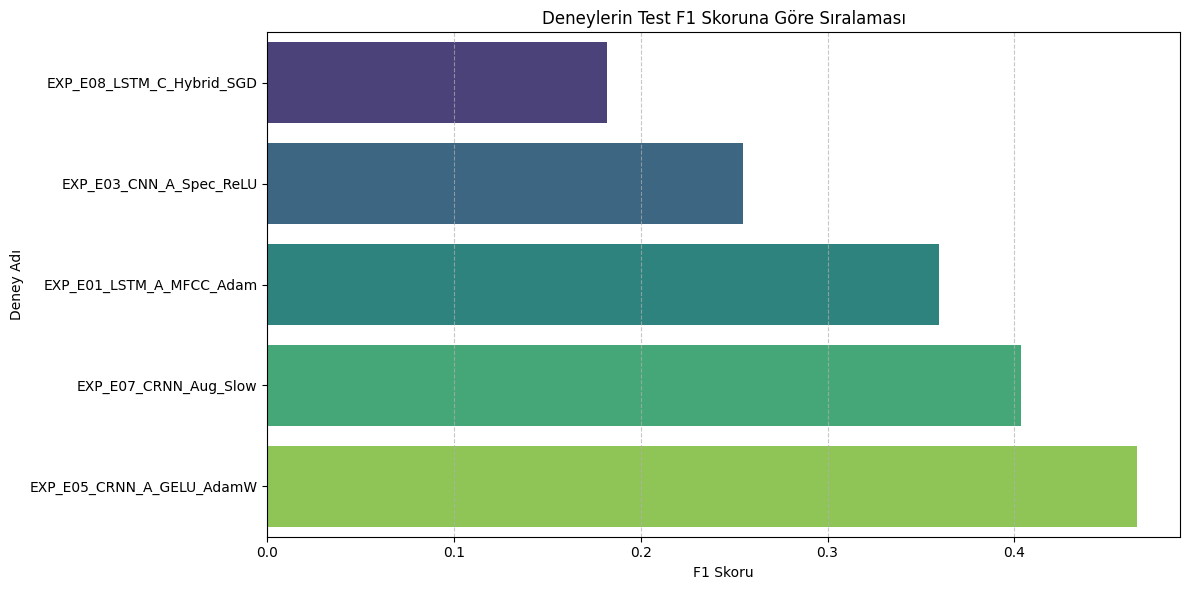

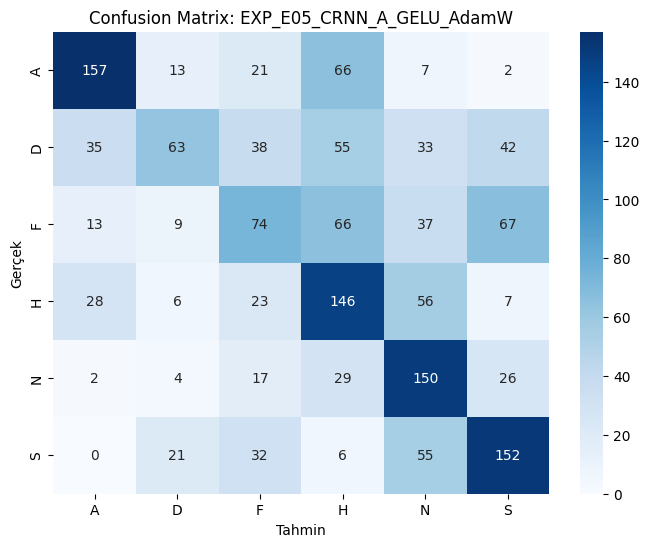

In [ ]:
# --- SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if RESULTS_DF.empty:
    print("Henüz hiç sonuç yok!")
else:
    print("--- Tüm Deney Sonuçlarının Özeti ---")
    # Okunabilirlik için ana sütunları seçelim
    summary_cols = ['experiment_name', 'test_accuracy', 'test_f1', 'model_type']
    print(RESULTS_DF[summary_cols].sort_values(by='test_accuracy', ascending=False))

    # En iyi deneyi bul
    # test_f1 sütunu bazen string olabilir, garantiye alalım
    RESULTS_DF['test_f1'] = pd.to_numeric(RESULTS_DF['test_f1'], errors='coerce')
    best_idx = RESULTS_DF['test_f1'].idxmax()
    best_row = RESULTS_DF.loc[best_idx]

    print(f"\n🏆 EN İYİ MODEL: {best_row['experiment_name']}")
    print(f"   F1 Skoru: {best_row['test_f1']:.4f}")

    # 1. Grafik: Model Karşılaştırması (Bar Plot)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='test_f1', y='experiment_name', data=RESULTS_DF.sort_values('test_f1'), palette='viridis')
    plt.title('Deneylerin Test F1 Skoruna Göre Sıralaması')
    plt.xlabel('F1 Skoru')
    plt.ylabel('Deney Adı')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 2. Grafik: En İyi Modelin Confusion Matrix'i
    if 'confusion_matrix' in best_row and isinstance(best_row['confusion_matrix'], (list, np.ndarray)):
        # String olarak geldiyse numpy array'e çevirmek gerekebilir,
        # ancak kod akışında list/array olarak kaldığını varsayıyoruz.
        cm = np.array(best_row['confusion_matrix'])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
        plt.title(f"Confusion Matrix: {best_row['experiment_name']}")
        plt.ylabel('Gerçek')
        plt.xlabel('Tahmin')
        plt.show()

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

# Library Imports
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast # Added for handling confusion matrix string
warnings.filterwarnings('ignore')

# ═══════════════════════════════════════════════════════════════════════════
# CONSTANTS AND DIRECTORIES
# ═══════════════════════════════════════════════════════════════════════════

DATA_ROOT = '/content/drive/MyDrive/crema_d/AudioWAV/'
OUTPUT_DIR = './experiments_log/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Seed for Reproducibility
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {DEVICE}")

# Emotion Label Mapping
LABEL_MAP = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
NUM_CLASSES = len(LABEL_MAP)
EMOTION_LABELS = list(LABEL_MAP.keys())

# Audio Feature Settings
TARGET_SR = 22050
MAX_LENGTH = 3.5
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128
N_MFCC = 40

# Global Variable for Normalization Stats
FEATURE_STATS = {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🖥️  Device: cpu


In [ ]:
def load_audio(file_path):
    """Load audio at target sample rate and pad/truncate to fixed length."""
    audio, sr = librosa.load(file_path, sr=TARGET_SR)
    max_samples = int(MAX_LENGTH * sr)
    if len(audio) > max_samples:
        audio = audio[:max_samples]
    elif len(audio) < max_samples:
        padding = np.zeros(max_samples - len(audio))
        audio = np.concatenate((audio, padding))
    return audio

# CREMA-D Emotion Code Mapper
EMOTION_CODE_MAPPER = {
    'ANG': 'A', 'DIS': 'D', 'FEA': 'F', 'HAP': 'H', 'NEU': 'N', 'SAD': 'S'
}
VALID_EMOTION_CODES_3CHAR = set(EMOTION_CODE_MAPPER.keys())

def create_cremad_dataframe(data_root):
    """Parse CREMA-D filenames and create DataFrame."""
    file_paths = []
    actor_ids = []
    emotions = []

    for filename in os.listdir(data_root):
        if filename.endswith(".wav"):
            base_filename = filename[:-4]
            parts = base_filename.split('_')

            if len(parts) < 4:
                continue

            emotion_code_3char = parts[2].upper()

            if emotion_code_3char not in VALID_EMOTION_CODES_3CHAR:
                continue

            emotion_code_1char = EMOTION_CODE_MAPPER[emotion_code_3char]
            actor_id = parts[0]

            file_paths.append(os.path.join(data_root, filename))
            actor_ids.append(actor_id)
            emotions.append(emotion_code_1char)

    df = pd.DataFrame({
        'path': file_paths,
        'actor_id': actor_ids,
        'emotion': emotions
    })

    print(f"📊 Total files processed: {len(df)}")
    return df

# Load and Split Data (Speaker-Independent)
df_full = create_cremad_dataframe(DATA_ROOT)
actor_list = df_full['actor_id'].unique()
train_actors, test_actors = train_test_split(
    actor_list, test_size=0.2, random_state=SEED
)

train_df = df_full[df_full['actor_id'].isin(train_actors)]
test_df = df_full[df_full['actor_id'].isin(test_actors)]

# Calculate Class Weights
emotion_counts = train_df['emotion'].value_counts()
total_samples = emotion_counts.sum()
class_weights = total_samples / (NUM_CLASSES * emotion_counts)
sorted_weights = [class_weights[e] for e in EMOTION_LABELS]
WEIGHTS_TENSOR = torch.tensor(sorted_weights, dtype=torch.float32).to(DEVICE)

print(f"👥 Training Speakers: {len(train_actors)}, Test Speakers: {len(test_actors)}")
print(f"⚖️  Class Weights: {WEIGHTS_TENSOR.cpu().numpy()}")

📊 Total files processed: 2945
👥 Training Speakers: 29, Test Speakers: 8
⚖️  Class Weights: [0.97559965 0.97559965 0.97559965 0.97559965 1.1429263  0.97559965]


In [ ]:
def preproc_A(audio):
    """Pipeline A: Baseline - Simple Normalization."""
    return audio

def preproc_B(audio, sr=TARGET_SR):
    """Pipeline B: Data Augmentation (Pitch Shift + Noise)."""
    pitch_shifted = librosa.effects.pitch_shift(
        audio, sr=sr, n_steps=random.uniform(-4, 4)
    )
    noise_amp = 0.005 * np.random.uniform() * np.amax(pitch_shifted)
    noisy_audio = pitch_shifted + noise_amp * np.random.normal(size=pitch_shifted.shape[0])
    return noisy_audio

def preproc_C(audio):
    """Pipeline C: RMS Normalization."""
    rms = np.sqrt(np.mean(audio**2))
    normalized_audio = audio / (rms + 1e-6)
    return normalized_audio

PREPROC_PIPELINES = {
    'A_Baseline': preproc_A,
    'B_Augmentation': preproc_B,
    'C_RMS_Norm': preproc_C
}

In [ ]:
def features_A(audio, sr=TARGET_SR):
    """Features A: MFCC + Delta + Delta-Delta."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    combined_features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
    return combined_features.T

def features_B(audio, sr=TARGET_SR):
    """Features B: Log-Mel Spectrogram + Delta + Delta-Delta (3-Channel)."""
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    delta = librosa.feature.delta(log_mel_spectrogram)
    delta2 = librosa.feature.delta(log_mel_spectrogram, order=2)
    combined_features = np.stack([log_mel_spectrogram, delta, delta2], axis=0)
    return combined_features

def features_C(audio, sr=TARGET_SR):
    """Features C: Hybrid MFCC + Spectral Features."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_LENGTH)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    combined_features = np.concatenate((mfcc, chroma, centroid, bandwidth), axis=0)
    return combined_features.T

FEATURE_PIPELINES = {
    'A_MFCC_Delta': features_A,
    'B_LogMelSpec_3Ch': features_B,
    'C_Hybrid_1D': features_C
}

In [ ]:
class SpecAugment:
    """
    SpecAugment: Time and Frequency Masking for Spectrograms.
    Reference: Park et al., 2019 - SpecAugment
    """
    def __init__(self, freq_mask_param=15, time_mask_param=20,
                 num_freq_masks=1, num_time_masks=2):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def __call__(self, spec):
        """Apply SpecAugment to spectrogram tensor."""
        spec = spec.clone()

        if len(spec.shape) == 2:
            spec = spec.unsqueeze(0)
            squeeze_output = True
        else:
            squeeze_output = False

        channels, n_freqs, n_frames = spec.shape

        # Frequency Masking
        for _ in range(self.num_freq_masks):
            f = random.randint(0, self.freq_mask_param)
            f0 = random.randint(0, max(0, n_freqs - f))
            spec[:, f0:f0+f, :] = 0

        # Time Masking
        for _ in range(self.num_time_masks):
            t = random.randint(0, min(self.time_mask_param, n_frames))
            t0 = random.randint(0, max(0, n_frames - t))
            spec[:, :, t0:t0+t] = 0

        if squeeze_output:
            spec = spec.squeeze(0)

        return spec

In [ ]:
class SERDataset(Dataset):
    """Speech Emotion Recognition Dataset with Optional SpecAugment."""
    def __init__(self, df, preproc_name, feature_name, stats=None, augment=False):
        self.df = df
        self.preproc = PREPROC_PIPELINES[preproc_name]
        self.feature_extractor = FEATURE_PIPELINES[feature_name]
        self.labels = [LABEL_MAP[l] for l in df['emotion']]
        self.stats = stats
        self.augment = augment

        if self.augment:
            self.spec_augment = SpecAugment(
                freq_mask_param=15,
                time_mask_param=20,
                num_freq_masks=1,
                num_time_masks=2
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.iloc[idx]['path']
        label = self.labels[idx]

        audio = load_audio(file_path)
        audio = self.preproc(audio)
        features = self.feature_extractor(audio)

        features_tensor = torch.tensor(features, dtype=torch.float32)

        # Apply SpecAugment BEFORE normalization (only for 2D/3D features)
        if self.augment and len(features_tensor.shape) >= 2:
            features_tensor = self.spec_augment(features_tensor)

        # Normalize
        if self.stats:
            mean = self.stats['mean']
            std = self.stats['std']
            features_tensor = (features_tensor - mean) / (std + 1e-6)

        return features_tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
ACTIVATIONS = {
    'relu': nn.ReLU(),
    'leakyrelu': nn.LeakyReLU(),
    'gelu': nn.GELU()
}

def calculate_conv_output_dim(input_tensor_shape, model):
    """Calculate flattened dimension after conv layers."""
    # input_tensor_shape is (C, H, W)
    dummy_input = torch.zeros(1, *input_tensor_shape).to(DEVICE)
    with torch.no_grad():
        output = model.features(dummy_input)
        flattened_size = output.numel()
        return flattened_size // output.shape[0]

# ─────────────────────────────────────────────────────────────────────────────
# MODEL 1: CNN
# ─────────────────────────────────────────────────────────────────────────────

class Model_CNN_A(nn.Module):
    def __init__(self, input_shape, num_classes, activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        # input_shape is (C, H, W) where C is channel, H is N_MELS, W is N_FRAMES
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout_rate)
        )

        # Calculate flattened size based on input_shape (H, W)
        flattened_size = calculate_conv_output_dim(input_shape, self)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256), act,
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ─────────────────────────────────────────────────────────────────────────────
# MODEL 2: LSTM
# ─────────────────────────────────────────────────────────────────────────────

class Model_LSTM_A(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=128, num_layers=2,
                 activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]
        # input_size is the feature dimension (e.g., N_MFCC*3 or N_FEATURES_C)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64), act,
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)
        # Use the last output for classification
        final_state = lstm_out[:, -1, :]
        out = self.fc(final_state)
        return out

# ─────────────────────────────────────────────────────────────────────────────
# MODEL 3: CRNN (Standard)
# ─────────────────────────────────────────────────────────────────────────────

class Model_CRNN_A(nn.Module):
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16), act, nn.MaxPool2d(kernel_size=(1, 2)), # Only pooling on time dim (W)
            nn.Dropout(dropout_rate)
        )
        self.features = self.conv

        # Recalculate feature_size_after_conv to be safe.
        # MaxPool(1,2) halves the time steps (W) but keeps freq bins (H).
        # Assuming H is height (N_MELS)
        feature_size_after_conv = 16 * input_shape[1]

        self.rnn = nn.LSTM(feature_size_after_conv, hidden_size, num_layers, batch_first=True,
                           bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.conv(x) # x shape: (B, 16, H', W')
        # Permute to (B, W', C, H') for RNN preparation
        x = x.permute(0, 3, 1, 2)
        # Reshape to (B, W', C*H') -> (B, seq_len, input_size)
        x = x.reshape(x.size(0), x.size(1), -1)

        rnn_out, _ = self.rnn(x) # rnn_out shape: (B, seq_len, hidden_size*2)

        # Use the last output for classification
        final_state = rnn_out[:, -1, :]
        out = self.classifier(final_state)
        return out

# ─────────────────────────────────────────────────────────────────────────────
# MODEL 4: CRNN WITH ATTENTION (NEW!)
# ─────────────────────────────────────────────────────────────────────────────

class Model_CRNN_Attention(nn.Module):
    """CRNN with Self-Attention Mechanism."""
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='gelu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        # Convolutional Feature Extractor
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate)
        )
        self.features = self.conv

        # Assuming two (1, 2) MaxPools: W is divided by 4, H is kept constant.
        # H is input_shape[1]
        feature_size_after_conv = 64 * input_shape[1]

        # Bidirectional LSTM
        self.rnn = nn.LSTM(
            feature_size_after_conv,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Self-Attention Mechanism (Aligner: (B*seq_len*2*hidden_size) -> (B*seq_len*1))
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2, 128),
            act,
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: (B, C, H, W)

        # Conv layers
        x = self.conv(x) # x shape: (B, 64, H', W')

        # Reshape for RNN
        x = x.permute(0, 3, 1, 2) # x shape: (B, W', 64, H')
        x = x.reshape(x.size(0), x.size(1), -1) # x shape: (B, seq_len, input_size)

        # RNN
        rnn_out, _ = self.rnn(x) # rnn_out shape: (B, seq_len, hidden_size*2)

        # Attention mechanism: calculate weights
        attn_weights = self.attention(rnn_out) # attn_weights shape: (B, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)

        # Weighted sum (context vector)
        context = torch.sum(rnn_out * attn_weights, dim=1) # context shape: (B, hidden_size*2)

        # Classification
        out = self.classifier(context)
        return out

In [ ]:
def evaluate_model(model, data_loader, stage, return_full=False):
    """Evaluate model and return metrics."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in data_loader:
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    if return_full:
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=EMOTION_LABELS, zero_division=0)
        return accuracy, f1, cm, report
    return accuracy, f1

In [ ]:
def train_and_evaluate(config, train_df, test_df, weights_tensor):
    """Train and evaluate a single experiment configuration with LR Scheduler."""

    preproc_name = config['preproc']
    feature_name = config['features']
    batch_size = config['batch_size']
    epochs = config['epochs']

    print(f"\n{'='*80}")
    print(f"🚀 EXPERIMENT: {config['name']}")
    print(f"{'='*80}")

    # ─────────────────────────────────────────────────────────────────────────
    # Step 1: Calculate Normalization Statistics
    # ─────────────────────────────────────────────────────────────────────────

    temp_dataset = SERDataset(train_df, preproc_name, feature_name, stats=None, augment=False)
    temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
    features_all, _ = next(iter(temp_loader))

    if len(features_all.shape) > 2 and features_all.shape[1] == 1:
        features_all = features_all.squeeze(1)

    mean = features_all.mean(dim=0, keepdim=True).to('cpu')
    std = features_all.std(dim=0, keepdim=True).to('cpu')

    global FEATURE_STATS
    FEATURE_STATS[config['name']] = {'mean': mean, 'std': std}

    # ─────────────────────────────────────────────────────────────────────────
    # Step 2: Create Data Loaders with SpecAugment
    # ─────────────────────────────────────────────────────────────────────────

    train_dataset = SERDataset(
        train_df, preproc_name, feature_name,
        stats=FEATURE_STATS[config['name']],
        augment=True  # Enable SpecAugment for training
    )
    test_dataset = SERDataset(
        test_df, preproc_name, feature_name,
        stats=FEATURE_STATS[config['name']],
        augment=False  # No augmentation for testing
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ─────────────────────────────────────────────────────────────────────────
    # Step 3: Model Instantiation
    # ─────────────────────────────────────────────────────────────────────────

    sample_features, _ = next(iter(train_loader))
    input_shape = sample_features.shape

    if len(input_shape) > 2 and input_shape[1] == 1:
        sample_features = sample_features.squeeze(1)
        input_shape = sample_features.shape

    # Skip LSTM if input is 4D
    if config['model_type'] == 'LSTM_A' and len(input_shape) == 4:
        print(f"⚠️  EXPERIMENT SKIPPED: LSTM cannot handle 4D input (Shape: {input_shape})")
        return

    model_input_shape = input_shape[1:]

    if config['model_type'] == 'LSTM_A':
        model = Model_LSTM_A(
            input_size=model_input_shape[-1],
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)
    elif config['model_type'] == 'CNN_A':
        model = Model_CNN_A(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)
    elif config['model_type'] == 'CRNN_A':
        model = Model_CRNN_A(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)
    elif config['model_type'] == 'CRNN_Attention':
        model = Model_CRNN_Attention(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)
    else:
        raise ValueError(f"Unknown model type: {config['model_type']}")

    # ─────────────────────────────────────────────────────────────────────────
    # Step 4: Optimizer and Scheduler
    # ─────────────────────────────────────────────────────────────────────────

    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    elif config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    # ─────────────────────────────────────────────────────────────────────────
    # Step 5: Training Loop
    # ─────────────────────────────────────────────────────────────────────────

    best_val_accuracy = 0.0
    best_val_f1 = 0.0
    prev_lr = config['learning_rate']

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)

            features, labels = features.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in test_loader:
                if len(features.shape) > 2 and features.shape[1] == 1:
                    features = features.squeeze(1)

                features, labels = features.to(DEVICE), labels.to(DEVICE)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_acc, val_f1 = evaluate_model(model, test_loader, 'Validation')

        # Step the scheduler
        scheduler.step(avg_val_loss)

        # Get current learning rate and check if it changed
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"📉 Learning rate reduced: {prev_lr:.6f} → {current_lr:.6f}")
            prev_lr = current_lr

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Val F1: {val_f1:.4f} | LR: {current_lr:.6f}")

        # Save best model
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_val_f1 = val_f1
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth"))

    # ─────────────────────────────────────────────────────────────────────────
    # Step 6: Test Evaluation
    # ─────────────────────────────────────────────────────────────────────────

    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth")))
    test_acc, test_f1, cm, report = evaluate_model(model, test_loader, 'Test', return_full=True)

    print(f"\n{'─'*80}")
    print(f"📊 FINAL TEST RESULTS:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"{'─'*80}\n")

    # ─────────────────────────────────────────────────────────────────────────
    # Step 7: Save Results
    # ─────────────────────────────────────────────────────────────────────────

    new_row = {
        'experiment_name': config['name'],
        'preprocessing_pipeline': preproc_name,
        'feature_pipeline': feature_name,
        'model_type': config['model_type'],
        'activation': config['activation'],
        'optimizer': config['optimizer'],
        'learning_rate': config['learning_rate'],
        'dropout': config['dropout'],
        'batch_size': batch_size,
        'epochs': epochs,
        'val_accuracy': best_val_accuracy,
        'val_f1': best_val_f1,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'confusion_matrix': cm.tolist()
    }

    global RESULTS_DF
    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)
    RESULTS_DF.to_csv('experiments_results_checkpoint.csv', index=False)
    print("💾 Results saved to checkpoint file.")

In [ ]:
csv_path = 'experiments_results_checkpoint.csv'

if os.path.exists(csv_path):
    RESULTS_DF = pd.read_csv(csv_path)
    print(f"✅ Existing results loaded: {len(RESULTS_DF)} experiments found.")
else:
    RESULTS_DF = pd.DataFrame(columns=[
        'experiment_name', 'preprocessing_pipeline', 'feature_pipeline', 'model_type',
        'activation', 'optimizer', 'learning_rate', 'dropout', 'batch_size', 'epochs',
        'val_accuracy', 'val_f1', 'test_accuracy', 'test_f1', 'confusion_matrix'
    ])
    print("🆕 New results dataframe created.")

🆕 New results dataframe created.


In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# EXPERIMENT 9: CRNN with Attention + SpecAugment
# ─────────────────────────────────────────────────────────────────────────────

config_e09 = {
    'name': 'EXP_E09_CRNN_Attention_SpecAug',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_Attention',
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 32,
    'epochs': 30
}

print(f"\n{'#'*80}")
print(f"# STARTING: {config_e09['name']}")
print(f"{'#'*80}\n")

train_and_evaluate(config_e09, train_df, test_df, WEIGHTS_TENSOR)

# ─────────────────────────────────────────────────────────────────────────────
# EXPERIMENT 10: Ultimate Configuration (RMS + Attention + SpecAugment)
# ─────────────────────────────────────────────────────────────────────────────

config_e10 = {
    'name': 'EXP_E10_CRNN_Attention_RMS_SpecAug',
    'preproc': 'C_RMS_Norm',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_Attention',
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 2e-3,
    'dropout': 0.4,
    'batch_size': 24,
    'epochs': 40
}

print(f"\n{'#'*80}")
print(f"# STARTING: {config_e10['name']}")
print(f"{'#'*80}\n")

train_and_evaluate(config_e10, train_df, test_df, WEIGHTS_TENSOR)

print("\n" + "!"*80)
print("🎉 EĞİTİM TAMAMLANDI: CELL 11'deki tüm deneyler bitti.")
print("▶️ Lütfen sonuçları görmek ve görselleştirmek için **CELL 12**'yi çalıştırınız.")
print("!"*80)


################################################################################
# STARTING: EXP_E09_CRNN_Attention_SpecAug
################################################################################



NameError: name 'train_and_evaluate' is not defined

In [ ]:
if RESULTS_DF.empty:
    print("⚠️  No results to visualize!")
else:
    print("\n" + "="*80)
    print("📊 ALL EXPERIMENT RESULTS SUMMARY")
    print("="*80 + "\n")

    # Display summary table
    summary_cols = ['experiment_name', 'test_accuracy', 'test_f1', 'model_type']
    summary_table = RESULTS_DF[summary_cols].sort_values(by='test_f1', ascending=False)
    print(summary_table.to_string(index=False))

    # Find best model
    RESULTS_DF['test_f1'] = pd.to_numeric(RESULTS_DF['test_f1'], errors='coerce')
    best_idx = RESULTS_DF['test_f1'].idxmax()
    best_row = RESULTS_DF.loc[best_idx]

    print(f"\n{'='*80}")
    print(f"🏆 BEST MODEL: {best_row['experiment_name']}")
    print(f"   Test F1-Score: {best_row['test_f1']:.4f}")
    print(f"   Test Accuracy: {best_row['test_accuracy']:.4f}")
    print(f"   Model Type: {best_row['model_type']}")
    print(f"{'='*80}\n")

    # ─────────────────────────────────────────────────────────────────────────
    # PLOT 1: F1-Score Comparison Bar Chart
    # ─────────────────────────────────────────────────────────────────────────

    plt.figure(figsize=(14, 8))
    sorted_df = RESULTS_DF.sort_values('test_f1', ascending=True)

    colors = ['#FF6B6B' if 'Attention' not in name else '#4ECDC4'
              for name in sorted_df['experiment_name']]

    bars = plt.barh(sorted_df['experiment_name'], sorted_df['test_f1'], color=colors)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sorted_df['test_f1'])):
        plt.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

    plt.xlabel('Test F1-Score', fontsize=12, fontweight='bold')
    plt.ylabel('Experiment Name', fontsize=12, fontweight='bold')
    plt.title('Speech Emotion Recognition: All Experiments F1-Score Comparison',
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ─────────────────────────────────────────────────────────────────────────
    # PLOT 2: Best Model Confusion Matrix
    # ─────────────────────────────────────────────────────────────────────────

    if 'confusion_matrix' in best_row and best_row['confusion_matrix'] is not None:
        try:
            # Handle string representation of list
            if isinstance(best_row['confusion_matrix'], str):
                cm = np.array(ast.literal_eval(best_row['confusion_matrix']))
            else:
                cm = np.array(best_row['confusion_matrix'])

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                        xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS,
                        cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
            plt.title(f'Confusion Matrix: {best_row["experiment_name"]}\n'
                      f'Test F1: {best_row["test_f1"]:.4f}',
                      fontsize=14, fontweight='bold', pad=20)
            plt.ylabel('True Emotion', fontsize=12, fontweight='bold')
            plt.xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig('best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"⚠️  Could not plot confusion matrix: {e}")

    # ─────────────────────────────────────────────────────────────────────────
    # PLOT 3: Model Type Performance Comparison
    # ─────────────────────────────────────────────────────────────────────────

    plt.figure(figsize=(12, 6))
    model_type_performance = RESULTS_DF.groupby('model_type')['test_f1'].mean().sort_values()

    colors_model = plt.cm.viridis(np.linspace(0, 1, len(model_type_performance)))
    bars = plt.barh(model_type_performance.index, model_type_performance.values, color=colors_model)

    for i, (bar, val) in enumerate(zip(bars, model_type_performance.values)):
        plt.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=10, fontweight='bold')

    plt.xlabel('Average Test F1-Score', fontsize=12, fontweight='bold')
    plt.ylabel('Model Architecture', fontsize=12, fontweight='bold')
    plt.title('Performance by Model Architecture Type', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_type_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ All visualizations saved successfully!")
    print("   - experiment_comparison.png")
    print("   - best_model_confusion_matrix.png")
    print("   - model_type_comparison.png")

print("\n" + "="*80)
print("🎉 COMPLETE! All experiments finished and results saved.")
print("="*80)

-----

## 7\. Hücre 4.2 & 5.1: Deney Çalıştırma ve Sonuç Analizi 🚀

# --- SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if RESULTS_DF.empty:
    print("Henüz hiç sonuç yok!")
else:
    print("--- Tüm Deney Sonuçlarının Özeti ---")
    # Okunabilirlik için ana sütunları seçelim
    summary_cols = ['experiment_name', 'test_accuracy', 'test_f1', 'model_type']
    print(RESULTS_DF[summary_cols].sort_values(by='test_accuracy', ascending=False))

    # En iyi deneyi bul
    # test_f1 sütunu bazen string olabilir, garantiye alalım
    RESULTS_DF['test_f1'] = pd.to_numeric(RESULTS_DF['test_f1'], errors='coerce')
    best_idx = RESULTS_DF['test_f1'].idxmax()
    best_row = RESULTS_DF.loc[best_idx]

    print(f"\n🏆 EN İYİ MODEL: {best_row['experiment_name']}")
    print(f"   F1 Skoru: {best_row['test_f1']:.4f}")

    # 1. Grafik: Model Karşılaştırması (Bar Plot)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='test_f1', y='experiment_name', data=RESULTS_DF.sort_values('test_f1'), palette='viridis')
    plt.title('Deneylerin Test F1 Skoruna Göre Sıralaması')
    plt.xlabel('F1 Skoru')
    plt.ylabel('Deney Adı')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 2. Grafik: En İyi Modelin Confusion Matrix'i
    if 'confusion_matrix' in best_row and isinstance(best_row['confusion_matrix'], (list, np.ndarray)):
        # String olarak geldiyse numpy array'e çevirmek gerekebilir,
        # ancak kod akışında list/array olarak kaldığını varsayıyoruz.
        cm = np.array(best_row['confusion_matrix'])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
        plt.title(f"Confusion Matrix: {best_row['experiment_name']}")
        plt.ylabel('Gerçek')
        plt.xlabel('Tahmin')
        plt.show()